In [1]:
#https://docs.ray.io/en/latest/train/examples/train_fashion_mnist_example.html

In [2]:
%xmode Minimal

Exception reporting mode: Minimal


In [3]:
import os
import glob
import random
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.modules.utils import consume_prefix_in_state_dict_if_present
#import torch.nn.functional as F
import torchvision
from torchvision.transforms import ToTensor, Resize,Compose, ToPILImage

from sklearn.metrics import classification_report, confusion_matrix

import ray
from ray import train
from ray.air import session, Checkpoint
from ray.air.config import ScalingConfig
from ray.train.torch import TorchCheckpoint, TorchTrainer

from ray.data.datasource import SimpleTorchDatasource
from ray.data.preprocessors import Concatenator, Chain, StandardScaler

from ray import tune
from ray.tune .tuner import Tuner, TuneConfig
from ray.air.config import RunConfig

import matplotlib.pyplot as plt

from ray_cluster_control import start_ray_cluster, stop_ray_cluster

In [4]:
start_ray_cluster("kubecon-2022")
os.getenv("RAY_CLUSTER_NAME")

RayCluster "kubecon-2022" has started
Access your cluster dashboard at http://ray-dashboard-kubecon-2022-open-data-hub.apps.et-gpu.zfq7.p1.openshiftapps.com


'kubecon-2022'

In [5]:
ray.init('ray://{ray_head}-ray-head:10001'.format(ray_head=os.environ['RAY_CLUSTER_NAME']))

Python version:,3.8.12
Ray version:,2.0.0
Dashboard:,http://10.131.2.243:8265


In [6]:
transforms = Compose([Resize((64,64)),ToTensor()])

In [7]:
pet_data = torchvision.datasets.OxfordIIITPet("data/",
                                              download = True,
                                              target_types = "category",
                                              transform = transforms,
                                              split = "trainval")
data_loader = torch.utils.data.DataLoader(pet_data, batch_size=4, shuffle=True)

This data set is only 3K and not the full 7k since we read in dataset with the `split` parameters that pulls in the files based on the corresponding txt file in `data/data/oxford-iiit-pet/annotations`

In [8]:
len(pet_data)

3680

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# for this demo we are letting Ray handle all the GPU work external
# to this notebook
device = "cpu"

cpu


Feature batch shape: torch.Size([4, 3, 64, 64])
Labels batch shape: torch.Size([4])


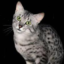

label:11


In [10]:
train_features, train_labels = next(iter(data_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
make = ToPILImage()
make(train_features[0]).show()
print(f'label:{train_labels[0]}')

### Pet Data is courtesy of Community Data License Agreement (CDLA) via Linux Foundation

In [11]:
def ConvNet():
    return nn.Sequential(
        nn.Conv2d(3, 16, 3, 1),
        nn.MaxPool2d(2, 2),
        nn.Conv2d(16, 32, 3,1 ),
        nn.MaxPool2d(2, 2),
        nn.Flatten(),
        nn.Linear(6272 , 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 37)
    )

In [12]:
net = ConvNet()
net.to(device)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Flatten(start_dim=1, end_dim=-1)
  (5): Linear(in_features=6272, out_features=128, bias=True)
  (6): ReLU()
  (7): Linear(in_features=128, out_features=64, bias=True)
  (8): ReLU()
  (9): Linear(in_features=64, out_features=37, bias=True)
)

In [13]:
dataset_factory = lambda: torchvision.datasets.OxfordIIITPet("data/", download = True, target_types = "category", transform = transforms, split = "trainval")
dataset = ray.data.read_datasource(
    SimpleTorchDatasource(), parallelism=1, dataset_factory=dataset_factory
)

In [14]:
train_dataset, valid_dataset = dataset.train_test_split(test_size=0.5, shuffle=True)

Shuffle Reduce: 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


In [15]:
def train_epoch(dataloader, model, loss_fn, optim):
    model.train()
    model.to("cuda")
    for batch_idx, data in enumerate(dataloader.iter_batches()):
        X = [x[0] for x in data]
        X = torch.stack(X)
        X = X.to("cuda")
        y = [torch.tensor(x[1]) for x in data]
        y = torch.stack(y)
        y = y.to("cuda") 
        pred = model(X)
        loss = loss_fn(pred, y)
        
        #backprop
        optim.zero_grad()
        loss.backward()
        optim.step()
        
    return loss.item()


def validate_epoch(dataloader, model, loss_fn):
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for data in dataloader.iter_batches():
            X = [x[0] for x in data]
            X = torch.stack(X)
            X = X.to("cuda")
            y = [torch.tensor(x[1]) for x in data]
            y = torch.stack(y)
            y = y.to("cuda")
            pred = model(X)
            test_loss = loss_fn(pred, y).item()  
    
    return test_loss


def train_loop_per_worker(config):
    batch_size = config["batch_size"]
    lr = config["lr"]
    epochs = config["epochs"]
    momentum = config["momentum"]
    tune_run = config["tune_run"]

    train_dataloader = train.get_dataset_shard("train")
    test_dataloader = train.get_dataset_shard("test")
    model = ConvNet()
    model = train.torch.prepare_model(model).to("cuda")
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr,  momentum=momentum)

    loss_results = []
    eval_results = []

    for epoch in range(epochs):
        loss = train_epoch(train_dataloader, model, loss_fn, optimizer)
        val_loss = validate_epoch(test_dataloader, model, loss_fn)
        loss_results.append(loss)
        eval_results.append(val_loss)
        session.report({"loss":loss},)

    session.report({"loss":loss, "model": model,
                   "training_loss": loss_results,"eval_loss": eval_results},
                   checkpoint=Checkpoint.from_dict(dict(epoch=epoch, model=model.state_dict())))

In [16]:
trainer = TorchTrainer(
    train_loop_per_worker=train_loop_per_worker,
    train_loop_config = {
        "batch_size": 4,
        "epochs": 100,
        "momentum": 0.9,
        "lr": 0.001,
        "tune_run": False
    },
    scaling_config = ScalingConfig(num_workers = 1,
                                   use_gpu = True,
                                   trainer_resources = {"CPU":1}),
    run_config = RunConfig(name = "test_run",
                           local_dir = "./",
                           sync_config = tune.SyncConfig(syncer=None)),
    datasets = {
        "train": train_dataset,
        "test": valid_dataset
    },
)

In [17]:
# Define a tuning search space.
search_space = {
    "train_loop_config": {
        "lr": tune.grid_search([0.001, 0.01]),
        "momentum": tune.grid_search([0.5, 0.9]),
        "batch_size": tune.grid_search([4]), 
        "epochs": tune.grid_search([100]),
        "tune_run": tune.grid_search([True])
    }
}

metric = "loss"
mode = "min"

tuner = Tuner(trainer,
              param_space=search_space,
              tune_config=TuneConfig(num_samples=1, metric=metric, mode=mode),
             )

In [18]:
%%time
result_grid = tuner.fit()

(TunerInternal pid=5159) == Status ==
(TunerInternal pid=5159) Current time: 2022-10-21 22:15:26 (running for 00:00:03.44)
(TunerInternal pid=5159) Memory usage on this node: 6.6/30.9 GiB
(TunerInternal pid=5159) Using FIFO scheduling algorithm.
(TunerInternal pid=5159) Resources requested: 1.0/2 CPUs, 1.0/2 GPUs, 0.0/8.4 GiB heap, 0.0/3.47 GiB objects
(TunerInternal pid=5159) Result logdir: /home/ray/test_run
(TunerInternal pid=5159) Number of trials: 4/4 (3 PENDING, 1 RUNNING)
(TunerInternal pid=5159) +--------------------------+----------+-------------------+------------------------+------------------------+------------------------+------------------------+------------------------+
(TunerInternal pid=5159) | Trial name               | status   | loc               |   train_loop_config... |   train_loop_config... |   train_loop_config/lr |   train_loop_config... | train_loop_config...   |
(TunerInternal pid=5159) |--------------------------+----------+-------------------+------------

(RayTrainWorker pid=5255) 2022-10-21 22:15:29,716	INFO config.py:71 -- Setting up process group for: env:// [rank=0, world_size=1]
(RayTrainWorker pid=5255) 2022-10-21 22:15:29,911	INFO train_loop_utils.py:300 -- Moving model to device: cuda:0


(TunerInternal pid=5159) == Status ==
(TunerInternal pid=5159) Current time: 2022-10-21 22:15:31 (running for 00:00:08.45)
(TunerInternal pid=5159) Memory usage on this node: 7.9/30.9 GiB
(TunerInternal pid=5159) Using FIFO scheduling algorithm.
(TunerInternal pid=5159) Resources requested: 1.0/2 CPUs, 1.0/2 GPUs, 0.0/8.4 GiB heap, 0.0/3.47 GiB objects
(TunerInternal pid=5159) Result logdir: /home/ray/test_run
(TunerInternal pid=5159) Number of trials: 4/4 (3 PENDING, 1 RUNNING)
(TunerInternal pid=5159) +--------------------------+----------+-------------------+------------------------+------------------------+------------------------+------------------------+------------------------+
(TunerInternal pid=5159) | Trial name               | status   | loc               |   train_loop_config... |   train_loop_config... |   train_loop_config/lr |   train_loop_config... | train_loop_config...   |
(TunerInternal pid=5159) |--------------------------+----------+-------------------+------------

(RayTrainWorker pid=234, ip=10.128.2.79) 2022-10-21 22:15:45,732	INFO config.py:71 -- Setting up process group for: env:// [rank=0, world_size=1]
(RayTrainWorker pid=234, ip=10.128.4.75) 2022-10-21 22:15:45,699	INFO config.py:71 -- Setting up process group for: env:// [rank=0, world_size=1]
(RayTrainWorker pid=234, ip=10.128.4.75) 2022-10-21 22:15:45,871	INFO train_loop_utils.py:300 -- Moving model to device: cuda:0
(RayTrainWorker pid=234, ip=10.128.2.79) 2022-10-21 22:15:45,924	INFO train_loop_utils.py:300 -- Moving model to device: cuda:0


(TunerInternal pid=5159) Result for TorchTrainer_db9da_00000:
(TunerInternal pid=5159)   _time_this_iter_s: 1.0058681964874268
(TunerInternal pid=5159)   _timestamp: 1666390545
(TunerInternal pid=5159)   _training_iteration: 15
(TunerInternal pid=5159)   date: 2022-10-21_22-15-45
(TunerInternal pid=5159)   done: false
(TunerInternal pid=5159)   experiment_id: 2eced6db495d47e3884ccd2881ed51d8
(TunerInternal pid=5159)   hostname: kubecon-2022-ray-cluster-kubecon-2022-head-fdbbh
(TunerInternal pid=5159)   iterations_since_restore: 15
(TunerInternal pid=5159)   loss: 3.597440719604492
(TunerInternal pid=5159)   node_ip: 10.131.2.243
(TunerInternal pid=5159)   pid: 5222
(TunerInternal pid=5159)   time_since_restore: 18.995596885681152
(TunerInternal pid=5159)   time_this_iter_s: 1.0057284832000732
(TunerInternal pid=5159)   time_total_s: 18.995596885681152
(TunerInternal pid=5159)   timestamp: 1666390545
(TunerInternal pid=5159)   timesteps_since_restore: 0
(TunerInternal pid=5159)   traini

(RayTrainWorker pid=327, ip=10.128.2.79) 2022-10-21 22:16:53,625	INFO config.py:71 -- Setting up process group for: env:// [rank=0, world_size=1]
(RayTrainWorker pid=327, ip=10.128.2.79) 2022-10-21 22:16:53,804	INFO train_loop_utils.py:300 -- Moving model to device: cuda:0


(TunerInternal pid=5159) Result for TorchTrainer_db9da_00001:
(TunerInternal pid=5159)   _time_this_iter_s: 0.6152818202972412
(TunerInternal pid=5159)   _timestamp: 1666390613
(TunerInternal pid=5159)   _training_iteration: 95
(TunerInternal pid=5159)   date: 2022-10-21_22-16-53
(TunerInternal pid=5159)   done: false
(TunerInternal pid=5159)   experiment_id: f21dc51fc8b2460db5f142df235a6505
(TunerInternal pid=5159)   hostname: kubecon-2022-ray-cluster-example-worker-v7c2t
(TunerInternal pid=5159)   iterations_since_restore: 95
(TunerInternal pid=5159)   loss: 2.404608726501465
(TunerInternal pid=5159)   node_ip: 10.128.4.75
(TunerInternal pid=5159)   pid: 203
(TunerInternal pid=5159)   time_since_restore: 70.26891946792603
(TunerInternal pid=5159)   time_this_iter_s: 0.6150951385498047
(TunerInternal pid=5159)   time_total_s: 70.26891946792603
(TunerInternal pid=5159)   timestamp: 1666390613
(TunerInternal pid=5159)   timesteps_since_restore: 0
(TunerInternal pid=5159)   training_iter

(TunerInternal pid=5159) 2022-10-21 22:17:55,958	INFO tune.py:758 -- Total run time: 152.45 seconds (151.96 seconds for the tuning loop).


CPU times: user 497 ms, sys: 362 ms, total: 859 ms
Wall time: 2min 36s


In [27]:
best_result = result_grid.get_best_result()
best_model = best_result.metrics["model"]
model_scripted = torch.jit.script(best_model)
model_scripted.save('models/best_model_scripted.pt')
best_result.config['train_loop_config']

{'lr': 0.01, 'momentum': 0.9, 'batch_size': 4, 'epochs': 100, 'tune_run': True}

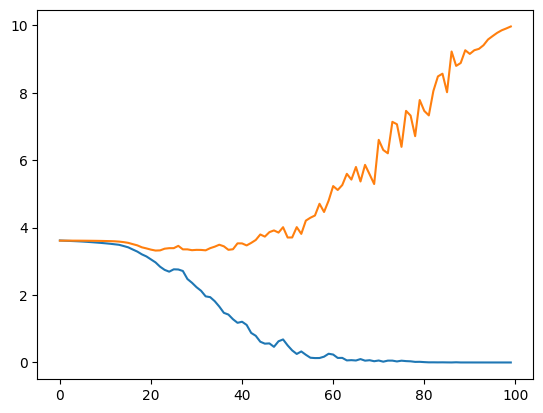

In [28]:
plt.plot(best_result.metrics["training_loss"])
plt.plot(best_result.metrics["eval_loss"])
plt.show()

In [21]:
model = torch.jit.load("models/best_model_scripted.pt") 
model.eval()

RecursiveScriptModule(
  original_name=Sequential
  (0): RecursiveScriptModule(original_name=Conv2d)
  (1): RecursiveScriptModule(original_name=MaxPool2d)
  (2): RecursiveScriptModule(original_name=Conv2d)
  (3): RecursiveScriptModule(original_name=MaxPool2d)
  (4): RecursiveScriptModule(original_name=Flatten)
  (5): RecursiveScriptModule(original_name=Linear)
  (6): RecursiveScriptModule(original_name=ReLU)
  (7): RecursiveScriptModule(original_name=Linear)
  (8): RecursiveScriptModule(original_name=ReLU)
  (9): RecursiveScriptModule(original_name=Linear)
)

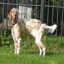

label:13
prediction: 13


In [22]:
train_features, train_labels = next(iter(data_loader))
make = ToPILImage()
make(train_features[0]).show()
print(f'label:{train_labels[0]}')
logits = model(train_features[0].reshape(1,3,64,64).to(device))
print(f"prediction: {torch.argmax(logits).item()}")

In [23]:
X = []
y = []
y_pred = []

for data in valid_dataset.iter_rows():
    X.append(data[0])
    y.append(data[1])
    logit = model(data[0].reshape(1,3,64,64))
    y_pred.append(torch.argmax(logit))

In [24]:
from sklearn.metrics import accuracy_score, cohen_kappa_score
acc = accuracy_score(y_pred, y)
kap = cohen_kappa_score(y_pred, y)
print(f"Accuracy: {acc*100:.1f}%")
print(f"Random guess would yield {kap*100:.1f}%")
print(f"Model outperforms Random chance by a factor of {(acc/kap):.2f}")

Accuracy: 10.1%
Random guess would yield 7.6%
Model outperforms Random chance by a factor of 1.32


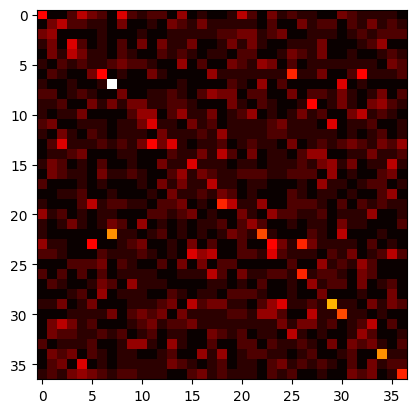

In [25]:
plt.imshow(confusion_matrix(y_pred,y), cmap='hot', interpolation='nearest')
plt.show()

In [26]:
print(os.getenv("RAY_CLUSTER_NAME"))
# can keep this if you want to run serving
#stop_ray_cluster()

kubecon-2022
